In [1]:
import os
import subprocess
import numpy as np
import librosa
import librosa.display
from scipy.signal import lfilter, get_window
from scipy.stats import skew, kurtosis
import soundfile as sf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import random
import pandas as pd
from tensorflow import keras

## Defs
### class OpenSmileFeatureSet

In [2]:
class OpenSmileFeatureSet:
    """利用openSmile工具进行特征提取"""
    dft_feature_file_save_path = os.getcwd()  # 默认特征集文件保存路径

    def __init__(self, input_file):
        """
        初始化
        :param input_file: 输入.wav音频文件，或是openSMILE所支持的文件格式
        """
        self.openSmile_path = ".\\openSMILE"
        self.input_file = input_file
        self.eGeMAPSv01a = ".\\config\\gemaps\\eGeMAPSv01a.conf"  # 2016-eGeMAPS特征集，共88个特征
        self.ComParE_2016 = ".\\config\\ComParE_2016.conf"  # 2016-ComParE特征集，共6373个特征
        self.IS09_emotion = ".\\config\\IS09_emotion.conf"  # 2009-InterSpeech Emotion Challenge特征集，共384个特征

    def feature_extraction(self, config_file, output_file):
        """
        利用openSmile工具特征提取
        :param config_file: 配置文件
        :param output_file: 输出特征.csv文件（-O命令，默认ARFF格式），修改“-O”命令，输出openSMILE所支持的文件格式
        :return: None
        """
        #cmd = "SMILExtract -noconsoleoutput -C %s -I %s -O %s" % (config_file, self.input_file, output_file)
        cmd = "SMILExtract -C \"%s\" -I \"%s\" -O \"%s\"" % (config_file, self.input_file, output_file)
        subprocess.run(cmd, cwd=self.openSmile_path, shell=True)

    def get_eGeMAPS(self, output_file=os.path.join(dft_feature_file_save_path, "eGeMAPS.csv")):
        """
        提取eGeMAPS特征集中的88维特征，详见会议论文集（2016 IEEE trans on Affective Computing）：
        https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7160715
        :param output_file: 输出特征.csv文件（-O命令，默认ARFF格式），修改“-O”命令，输出openSMILE所支持的文件格式
        :return: 88维特征
        """
        self.feature_extraction(self.eGeMAPSv01a, output_file)
        features = self.feature_file_reader(output_file)
        return features

    def get_ComParE(self, output_file=os.path.join(dft_feature_file_save_path, "ComParE_2016.csv")):
        """
        提取ComParE_2016特征集中的6373维特征，详见InterSpeech挑战赛论文集（2016 Computational Paralinguistics ChallengE）：
        https://www.isca-speech.org/archive/Interspeech_2016/pdfs/0129.PDF
        https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3664314/
        :param output_file: 输出特征.csv文件（-O命令，默认ARFF格式），修改“-O”命令，输出openSMILE所支持的文件格式
        :return: 6373维特征
        """
        self.feature_extraction(self.ComParE_2016, output_file)
        features = self.feature_file_reader(output_file)
        return features

    def get_IS09(self, output_file=os.path.join(dft_feature_file_save_path, "IS09_emotion.csv")):
        """
        提取IS09_emotion特征集中的384维特征，详见InterSpeech挑战赛论文集（The INTERSPEECH 2009 Emotion Challenge）：
        https://www.isca-speech.org/archive/archive_papers/interspeech_2009/papers/i09_0312.pdf
        :param output_file: 输出特征.csv文件（-O命令，默认ARFF格式），修改“-O”命令，输出openSMILE所支持的文件格式
        :return: 384维特征
        """
        self.feature_extraction(self.IS09_emotion, output_file)
        features = self.feature_file_reader(output_file)
        return features

    @staticmethod
    def feature_file_reader(feature_f):
        """
        读取生成的ARFF格式csv特征文件中特征值
        :param feature_f: ARFF格式csv特征文件
        :return: 特征
        """
        with open(feature_f) as f:
            last_line = f.readlines()[-1]  # ARFF格式csv文件最后一行包含特征数据
        features = last_line.split(",")
        features = np.array(features[1:-1], dtype="float64")  # 第2到倒数第二个为特征数据
        return features

### class RhythmFeatures

In [3]:
class RhythmFeatures:
    """韵律学特征"""
    def __init__(self, input_file, sr=None, frame_len=2205, n_fft=None, win_step=2 / 3, window="hamming"):
        """
        初始化
        :param input_file: 输入音频文件
        :param sr: 所输入音频文件的采样率，默认为None
        :param frame_len: 帧长，默认2205个采样点(50ms,44.1kHz),与窗长相同
        :param n_fft: FFT窗口的长度，默认与窗长相同
        :param win_step: 窗移，默认移动2/3，2205*2/3=341个采样点(33ms,44.1kHz)
        :param window: 窗类型，默认汉明窗
        """
        self.input_file = input_file
        self.frame_len = frame_len  # 帧长，单位采样点数
        self.wave_data, self.sr = librosa.load(self.input_file, sr=sr)
        self.window_len = frame_len  # 窗长
        if n_fft is None:
            self.fft_num = self.window_len  # 设置NFFT点数与窗长相等
        else:
            self.fft_num = n_fft
        self.win_step = win_step
        self.hop_length = round(self.window_len * win_step)  # 重叠部分采样点数设置为窗长的1/3（1/3~1/2）,即帧移(窗移)2/3
        self.window = window

    def short_time_energy(self):
        """
        计算语音短时能量：每一帧中所有语音信号的平方和
        :return: 语音短时能量列表(值范围0-每帧归一化后能量平方和，这里帧长512，则最大值为512)，
        np.ndarray[shape=(1，无加窗，帧移为0的n_frames), dtype=float64]
        """
        energy = []  # 语音短时能量列表
        energy_sum_per_frame = 0  # 每一帧短时能量累加和
        for i in range(len(self.wave_data)):  # 遍历每一个采样点数据
            energy_sum_per_frame += self.wave_data[i] ** 2  # 求语音信号能量的平方和
            if (i + 1) % self.frame_len == 0:  # 一帧所有采样点遍历结束
                energy.append(energy_sum_per_frame)  # 加入短时能量列表
                energy_sum_per_frame = 0  # 清空和
            elif i == len(self.wave_data) - 1:  # 不满一帧，最后一个采样点
                energy.append(energy_sum_per_frame)  # 将最后一帧短时能量加入列表
        energy = np.array(energy)
        energy = np.where(energy == 0, np.finfo(np.float64).eps, energy)  # 避免能量值为0，防止后续取log出错(eps是取非负的最小值)
        return energy

    def energy(self):
        """
        每帧内所有采样点的幅值平方和作为能量值
        :return: 每帧能量值，np.ndarray[shape=(1，n_frames), dtype=float64]
        """
        mag_spec = np.abs(librosa.stft(self.wave_data, n_fft=self.fft_num, hop_length=self.hop_length,
                                       win_length=self.frame_len, window=self.window))
        pow_spec = np.square(mag_spec)
        energy = np.sum(pow_spec, axis=0)
        energy = np.where(energy == 0, np.finfo(np.float64).eps, energy)  # 避免能量值为0，防止后续取log出错(eps是取非负的最小值)
        return energy


## Generate dataset

### initialize (for multi .wav processing)

In [241]:
dataset_times=[]
dataset_params=[]
dataset_features=[]

### load and sort params

In [248]:
raw_wave_path="D:\\autocover_test\\sequential\\dataset\\"
raw_wave_dec="_MixDown.wav"

index=8

raw_wave_file=raw_wave_path+str(index)+raw_wave_dec
wave_data,_=librosa.load(raw_wave_file, sr=44100)

f=open(raw_wave_path+"params.txt")
t_params=[]
params=np.zeros(shape=(5,8000,2), dtype=np.float)
c=0
for line in f:
    t=line.strip()
    t_params.append(t.split(' '))
    t_params[-1]=t_params[-1][3:]
    for i in range(5):
        t=t_params[-1][i].split('+')
        params[i][c][0],params[i][c][1]=float(t[1])*0.25,float(t[0])        
    c=c+1
f.close()

#sort by time
params=params[:,(index-1)*1000:index*1000,:]
for i in range(5):
    t=params[i,:,:]
    params[i,:,:]=t[np.argsort(t,axis=0)[:,0],:]
print(params[:,:2,:]*44100)

[[[ 7.71750000e+03 -1.46069411e+03]
  [ 2.42550000e+04  2.06999092e+04]]

 [[ 7.71750000e+03 -1.98087965e+04]
  [ 3.08700000e+04  1.68124472e+04]]

 [[ 1.43325000e+04  3.77656043e+04]
  [ 2.64600000e+04  3.64786261e+04]]

 [[ 7.71750000e+03 -3.52331829e+03]
  [ 3.08700000e+04 -2.89244591e+03]]

 [[ 7.71750000e+03  6.30284161e+06]
  [ 2.64600000e+04 -1.66318234e+07]]]


### randomly generate dataset

In [249]:
N_sample=2000
count=0
while count<N_sample:
    timet=random.randint(40000,len(wave_data)-40000)
    t_param=[0,0,0,0,0]
    flag=True
    for i in range(5):
        t=params[i,:,0]        
        t_left=params[i,np.where(t*44100<=timet),0]
        t_right=params[i,np.where(t*44100>=timet),0]
        if t_left[0,-1]==t_left[0,-2] or t_right[0,0]==t_right[0,1] or t_left[0,-1]==t_right[0,0]:
            flag=False
            break
        t_left=t_left[0,-1]
        t_right=t_right[0,0]
        p_left=params[i,np.where(t*44100<=timet),1]
        p_right=params[i,np.where(t*44100>=timet),1]
        p_left=p_left[0,-1]
        p_right=p_right[0,0]
        t_param[i]=p_left*(t_right-timet/44100)/(t_right-t_left)+p_right*(timet/44100-t_left)/(t_right-t_left);
    
    if flag: 
        count=count+1
        dataset_times.append(timet)
        dataset_params.append(t_param)
print(dataset_times[:5])
print(dataset_params[:5])
print(dataset_times[-5:])
print(dataset_params[-5:])

[4081903, 10258207, 1772844, 1243370, 4466990]
[[0.17436556761277433, 0.024578998294216888, 0.5838723737697635, -0.02251119677526346, -84.64950272293493], [0.1702099978593327, -0.23153811112210815, 0.30364023035975657, -0.055196713285191115, -76.71465053518355], [0.15697135492830566, 0.22293239306711596, 0.3061838005901608, -0.037056040816809244, -302.5375223114661], [-0.171516283666498, -0.18526575314120275, 0.5830765577539366, 0.026551213509636178, -111.73525821507155], [0.29503919851049176, -0.10948050735792224, 0.41301669586885653, -0.013983492758905959, 19.83575734154016]]
[2978283, 6075666, 5586954, 8738963, 5516297]
[[-0.35154019392879926, -0.3829738669390658, 0.6361444701318543, 0.012707968782988263, 0.6468788888443058], [0.013193314315920773, -0.45183322605783494, 0.3274288916995187, -0.018376244951488454, -139.0347294250043], [-0.16554814239246707, 0.5714385524087845, 0.582459908293998, 0.019691452256648326, -380.0037812147197], [-0.27958245675081145, -0.19418176731666653, 0.

### generate eGeMAPS features (88)

In [250]:
prev=0
for i in range(N_sample):
    if i*100/N_sample>prev:
        print(prev+5,'%')
        prev=prev+5
    sf.write(raw_wave_path+"temp.wav",wave_data[dataset_times[-(N_sample-i)]-2205:dataset_times[-(N_sample-i)]+2205],44100,"PCM_16")
    opensmile_f = OpenSmileFeatureSet(raw_wave_path+"temp.wav")
    feat = opensmile_f.get_eGeMAPS(feature_file)
    dataset_features.append(feat.tolist())
#print(dataset_features)

5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
55 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %
100 %


### test normalize data and find out the range

(6000, 88)
[[ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00  0.000000e+00  0.000000e+00 -3.427952e+00  0.000000e+00
   1.930438e-01  4.269111e-03  2.771379e-02  7.873833e-02  2.511056e-01
   5.377769e-03 -2.196546e+01  0.000000e+00 -5.035852e+01  0.000000e+00
   2.618378e-02  1.245521e-01 -4.323192e+01 -2.573287e+03 -5.076690e+01
  -1.667041e+03 -5.483699e+01 -4.141426e+03 -8.104925e+01 -3.443117e+02
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -1.982564e+01
  -3.016441e+02 -2.010000e+02 -8.864554e+03 -2.010000e+02 -6.026472e+02
   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -2.010000e+02
  -1.551192e+03  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
  -2.010000e+02 -1.194899e+02  0.000000e+00  0.000000e+00  0.000000e+00
   0.000000e+00 -2.010000e+02 -1.024701e+04 -3.624857e+01 -1.208528e+03
  -2.689866e+01 -2.890647e+01  0.000000e+00  0.000000e+00 -5.869857e-02
  -3.330090e+02  0.000000e+00  0.000000e+00 -4.613490

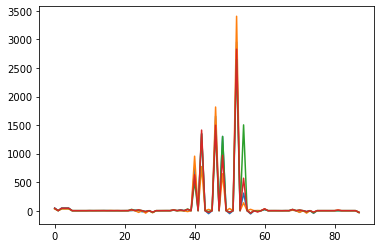

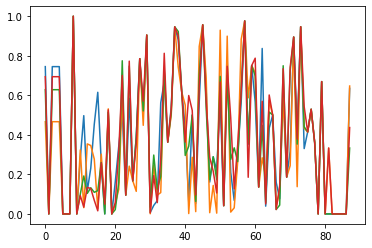

In [251]:
dataset_features=np.array(dataset_features)
print(np.shape(dataset_features))
"""
feature_range=[[],[]]
for i in range(88):
    feature_range[0].append(np.min(dataset_features[:,i]))
    feature_range[1].append(np.max(dataset_features[:,i]))
feature_range=np.array(feature_range)
"""
print(feature_range)
for j in range(4):
    plt.plot([i for i in range(88)],dataset_features[j][:])
plt.figure()
for j in range(4):
    t=dataset_features[j,:]
    t=(t-feature_range[0])/(feature_range[1]-feature_range[0]+1e-10)
    plt.plot([i for i in range(88)],t)

### save dataset

In [252]:
"""
f=open(raw_wave_path+"index.txt",'r')
for line in f:
    file_index=int(line)
f.close()
"""
dataframe = pd.DataFrame(dataset_features)
dataframe.to_csv(raw_wave_path+"features2.csv",index=False,sep=',')

for i in range(np.shape(dataset_features)[0]):
    dataset_features[i,:]=(dataset_features[i,:]-feature_range[0])/(feature_range[1]-feature_range[0]+1e-10)

dataframe = pd.DataFrame(dataset_features)
dataframe.to_csv(raw_wave_path+"norm_features2.csv",index=False,sep=',')

dataframe = pd.DataFrame(dataset_params)
dataframe.to_csv(raw_wave_path+"params2.csv",index=False,sep=',')

#dataframe = pd.DataFrame(feature_range)
#dataframe.to_csv(raw_wave_path+"feature_range.csv",index=False,sep=',')

## Sequential Model
### build model

In [7]:
model=keras.models.Sequential()
#model.add(keras.layers.Dense(16, activation='sigmoid',input_shape=(1,88)))
model.add(keras.layers.Dense(128, activation='relu',input_shape=(1,88),kernel_initializer='random_uniform'))
model.add(keras.layers.Dropout(0.005))
model.add(keras.layers.Dense(64, activation='relu',kernel_initializer='random_uniform'))
model.add(keras.layers.Dropout(0.005))
model.add(keras.layers.Dense(16, activation='relu',kernel_initializer='random_uniform'))
model.add(keras.layers.Dropout(0.005))
model.add(keras.layers.Dense(5, activation='linear',kernel_initializer='random_uniform'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 128)            11392     
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 64)             8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 16)             1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 16)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 5)              8

### get data ready

In [386]:
x=np.array(pd.read_csv(raw_wave_path+"norm_features.csv"))
x=np.expand_dims(x,1)
print(x.shape)

range_param=[[-0.5,0.5],[-0.75,0.75],[0.2,1],[-0.1,0.1],[-400,400]]
y=np.array(pd.read_csv(raw_wave_path+"params.csv"))
for i in range(5):
    y[:,i]=(y[:,i]-range_param[i][0])/(range_param[i][1]-range_param[i][0])
y=np.expand_dims(y,1)
print(y.shape)
print(y[0,:])

x2=np.array(pd.read_csv(raw_wave_path+"norm_features2.csv"))
x2=np.expand_dims(x2,1)
print(x2.shape)

range_param=[[-0.5,0.5],[-0.75,0.75],[0.2,1],[-0.1,0.1],[-400,400]]
y2=np.array(pd.read_csv(raw_wave_path+"params2.csv"))
for i in range(5):
    y2[:,i]=(y2[:,i]-range_param[i][0])/(range_param[i][1]-range_param[i][0])
y2=np.expand_dims(y2,1)
print(y2.shape)
print(y2[0,:])

x=np.concatenate((x,x2))
y=np.concatenate((y,y2))
print(x.shape)
print(y.shape)

(10000, 1, 88)
(10000, 1, 5)
[[0.28872258 0.68206747 0.18689351 0.7178625  0.33279585]]
(6000, 1, 88)
(6000, 1, 5)
[[0.67436557 0.516386   0.47984047 0.38744402 0.39418812]]
(16000, 1, 88)
(16000, 1, 5)


### brief PCA analysis of dataset

In [401]:
from sklearn.decomposition import PCA
t=np.squeeze(x)
pca = PCA(n_components='mle')
pca.fit(t)
# PCA(copy=True, n_components=2, whiten=False)
ratio=pca.explained_variance_ratio_
cdf=0
for i in range(len(ratio)):
    cdf=cdf+ratio[i]
    print(cdf)
    if cdf>0.99:
        print(i)

0.4195946642539879
0.536911834198194
0.59870486832394
0.6503314578839435
0.6900262235725401
0.7259216791597974
0.7590554467828531
0.782471386661846
0.8040150745280892
0.8213713117664976
0.8366508135528576
0.8510427932750884
0.8632664335511137
0.8749135823006627
0.8848311019810863
0.8938480664745366
0.9019772305769163
0.909982111505484
0.9168534306849363
0.9230619935560725
0.9285905201815874
0.9339086938258148
0.9389147076503646
0.94323326010387
0.9470794109421471
0.9508367739419731
0.9541360896787239
0.9571590699796235
0.9600820039176584
0.9628831691774351
0.9656541672420259
0.9682174820746062
0.9706409267128752
0.9730219467821999
0.975280275346911
0.9773807723238196
0.9791363722319575
0.9806732880111411
0.9821017230471716
0.983462557075055
0.9847418744943491
0.9859256907314772
0.987018001725058
0.9880808684269329
0.9890794081134808
0.9900307398132567
45
0.9908995918643628
46
0.9917379868560237
47
0.9924920021400794
48
0.9932172167738413
49
0.9938798703430807
50
0.9945352608306127
51
0

### train model

In [519]:
#opt=keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error',optimizer='SGD')
history=model.fit(x[:,:,:],y[:,:,:],batch_size=16,epochs=1500,verbose=1,validation_split=0.25,use_multiprocessing=False)

Epoch 1/1500
750/750 [==============================] - 1s 1ms/step - loss: 0.0306 - val_loss: 0.0518
Epoch 2/1500
750/750 [==============================] - 1s 1ms/step - loss: 0.0300 - val_loss: 0.0518
Epoch 3/1500
750/750 [==============================] - 1s 1ms/step - loss: 0.0298 - val_loss: 0.0520
Epoch 4/1500
750/750 [==============================] - 1s 1ms/step - loss: 0.0295 - val_loss: 0.0520
Epoch 5/1500
750/750 [==============================] - 1s 1ms/step - loss: 0.0294 - val_loss: 0.0521
Epoch 6/1500
750/750 [==============================] - 1s 1ms/step - loss: 0.0294 - val_loss: 0.0521
Epoch 7/1500
750/750 [==============================] - 1s 1ms/step - loss: 0.0293 - val_loss: 0.0522
Epoch 8/1500
750/750 [==============================] - 1s 1ms/step - loss: 0.0292 - val_loss: 0.0524
Epoch 9/1500
750/750 [==============================] - 1s 1ms/step - loss: 0.0292 - val_loss: 0.0523
Epoch 10/1500
750/750 [==============================] - 1s 1ms/step - loss: 0.029

KeyboardInterrupt: 

Text(0, 0.5, 'MSE')

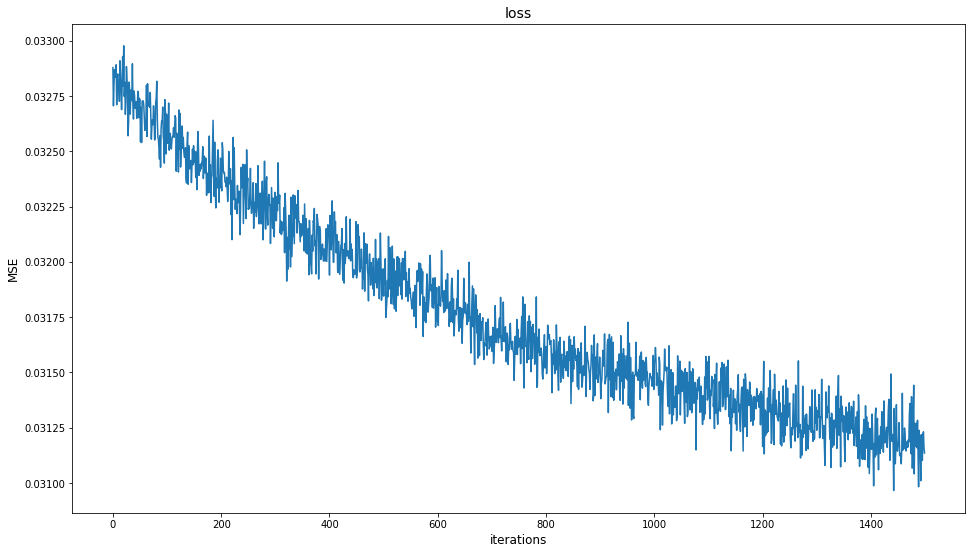

In [520]:
t=history.history['loss']
plt.figure(figsize=(16,9))
plt.plot([i for i in range(np.shape(t)[0])],t)
plt.title('loss',fontsize=14)
plt.xlabel('iterations',fontsize=12)
plt.ylabel('MSE',fontsize=12)
#plt.ylim([0,100])

[[0.5583742  0.833196   0.601575   0.6499964  0.5614276 ]
 [0.6307104  0.4594213  0.42024302 0.40589783 0.25896057]
 [0.6599026  0.3500519  0.844918   0.5456033  0.46421933]
 [0.38731462 0.30198717 0.58889747 0.5994232  0.7982595 ]
 [0.65816146 0.60477793 0.19493677 0.4006902  0.65566254]
 [0.6962524  0.7113152  0.6252396  0.5305716  0.67031974]
 [0.3068025  0.5663923  0.5580737  0.31005767 0.32573467]
 [0.6743492  0.61902046 0.62518233 0.60602856 0.35755104]
 [0.4082827  0.30693942 0.7114485  0.5695543  0.58962303]
 [0.30796012 0.3131895  0.6349326  0.32513672 0.36364424]
 [0.641773   0.69637835 0.6305575  0.4265218  0.37465933]
 [0.55282193 0.54530627 0.42306912 0.37875697 0.44144052]
 [0.43236387 0.257818   0.27651462 0.6955744  0.4470968 ]
 [0.3707391  0.535032   0.45412374 0.5419148  0.3234328 ]
 [0.1291345  0.5812738  0.2235716  0.49559736 0.61473304]
 [0.29855257 0.3014639  0.60107046 0.5183917  0.48344353]
 [0.5408404  0.32290435 0.778181   0.32957187 0.5731256 ]
 [0.3245104  0

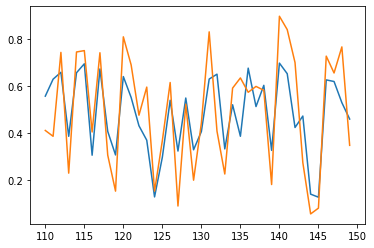

In [527]:
y_pred=keras.backend.function([model.input],[model.output])(x[110:150])
y_pred=np.squeeze(y_pred)
print(y_pred)
#print(y[110:130])
plt.plot([i for i in range(110,150)],y_pred[:,0])
plt.plot([i for i in range(110,150)],y[110:150,0,0])

### save model

In [528]:
#model.save("C:\\Users\\Lenovo\\Desktop\\autocover_test\\transformer\\models\\transformer1.h5")
model.save("D:\\autocover_test\\sequential\\models\\seq_4.h5")
import pickle
with open('D:\\autocover_test\\sequential\\models\\seq_4_history.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Analyse wave data
### load data

In [4]:
model = keras.models.load_model("D:\\autocover_test\\sequential\\models\\seq_4.h5")

In [43]:
current_path = os.getcwd()
wave_file = os.path.join(current_path, "audios\\wings_out.wav")
feature_file = os.path.join(current_path, "features\\feature.csv")
wave_data,_=librosa.load(wave_file, sr=44100)

### get energy

In [44]:
rhythm_f = RhythmFeatures(wave_file,win_step=1)
e=rhythm_f.short_time_energy()
print(np.shape(e))

(2128,)


### get eGeMAPS features

In [45]:
wave_features=[]
wave_timeindexs=[]

prev=0
for i in range(len(e)):
    if i*100/len(e)>prev:
        print(prev+5,'%')
        prev=prev+5
    if e[i]>0.5:
        index=int(i*0.05*44100)
        clip=wave_data[index-2205:index+2205] #100ms window, 50ms step
        sf.write(current_path+"\\audios\\test.wav",clip,44100,"PCM_16")
        opensmile_f = OpenSmileFeatureSet(current_path+"\\audios\\test.wav")
        try:
            feat = opensmile_f.get_eGeMAPS(feature_file)
            wave_features.append(feat.tolist())
            wave_timeindexs.append(i)
        except:
            wave_features.append(wave_features[-1])
            wave_features[-1][2]=wave_features[-1][2]/2
            wave_timeindexs.append(i)
#print(wave_timeindexs)

5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
55 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %
100 %


### feature normalization

In [46]:
raw_wave_path="D:\\autocover_test\\sequential\\dataset\\"

wave_features=np.squeeze(np.array(wave_features))

feature_range=np.array(pd.read_csv(raw_wave_path+"feature_range.csv"))
t=(wave_features-feature_range[0,:])/(feature_range[1,:]-feature_range[0,:]+1e-10)

wave_features=np.expand_dims(t,1)
print(np.shape(wave_features))

(1308, 1, 88)


### dump into the model and rescale and smooth

(1308, 5)
[[0.57790637 0.5039009  0.37453768 0.28671554 0.6246855 ]
 [0.65580475 0.5782362  0.5458108  0.3098148  0.83531463]
 [0.69807714 0.6057414  0.59607995 0.5233425  0.74151754]
 [0.61355394 0.568797   0.5320294  0.39067167 0.5644964 ]
 [0.6729237  0.58968496 0.6697571  0.44449425 0.6327126 ]]
below lower boundary ratio: 0.0
over higher boundary ratio: 0.0
below lower boundary ratio: 0.0007645259938837921
over higher boundary ratio: 0.0
below lower boundary ratio: 0.0
over higher boundary ratio: 0.0
below lower boundary ratio: 0.0
over higher boundary ratio: 0.0
below lower boundary ratio: 0.0
over higher boundary ratio: 0.009938837920489297
1174


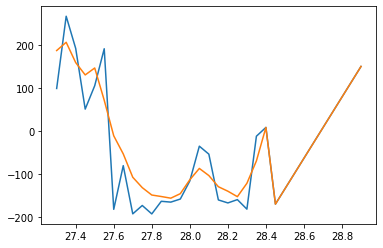

In [47]:
range_param=[[-0.5,0.5],[-0.75,0.75],[0.2,1],[-0.1,0.1],[-400,400]]

features_pred=keras.backend.function([model.input],[model.output])(wave_features)
features_pred=np.squeeze(features_pred)
print(np.shape(features_pred))

print(features_pred[10:15,:])
range_param_full=[[-1, 1], [-1, 1], [0, 1], [-1, 1], [-400, 400]]
for i in range(5):
    features_pred[:,i]= features_pred[:,i]*(range_param[i][1]-range_param[i][0])+range_param[i][0]
    if i==2:
        features_pred[:,i]=features_pred[:,i]*0.75
    t=np.where(features_pred[:,i]<range_param_full[i][0])
    features_pred[t,i]=range_param_full[i][0]
    print('below lower boundary ratio:',np.shape(t)[1]/len(wave_timeindexs))
    t=np.where(features_pred[:,i]>range_param_full[i][1])
    features_pred[t,i]=range_param_full[i][1]
    print('over higher boundary ratio:',np.shape(t)[1]/len(wave_timeindexs))
    #features_pred[]
    
smooth_index=[]
for i in range(3,len(wave_timeindexs)-3):
    #print(i,wave_timeindexs[i])
    t1=np.where(np.array(wave_timeindexs)>wave_timeindexs[i-3])[0][0]
    t2=np.where(np.array(wave_timeindexs)<wave_timeindexs[i+3])[0][-1]
    if wave_timeindexs[t2]-wave_timeindexs[t1]<=5:
        smooth_index.append(i)
        #print(wave_timeindexs[t1:t2])
print(len(smooth_index))
plt.plot(np.array(wave_timeindexs[10:35])*0.05,features_pred[10:35,4])

t=features_pred
for i in smooth_index:
    t[i,4]=np.mean(features_pred[i-2:i+2,4]) #toneshift
    t[i,1]=np.mean(features_pred[i-2:i+2,1]) #breathiness    
features_pred=t
plt.plot(np.array(wave_timeindexs[10:35])*0.05,t[10:35,4])

### write param.txt

In [41]:
f=open("D:\\autocover_test\\param.txt","w")
i=0
while i<len(wave_timeindexs):
    f.write(str.format('%.3f '%(features_pred[i,0]*1))) #tension
    f.write(str.format('%.3f '%features_pred[i,1])) #breathiness
    f.write(str.format('%.3f '%(features_pred[i,2]))) #voicing
    f.write(str.format('%.3f '%features_pred[i,3])) #gender
    f.write(str.format('%.3f '%(features_pred[i,4]*1))) #toneshift
    f.write(str.format('%.3f\n'%(wave_timeindexs[i]*0.05)))
    i=i+1
f.close()

In [42]:
features_ori=features_pred
wave_timeindexs_ori=wave_timeindexs

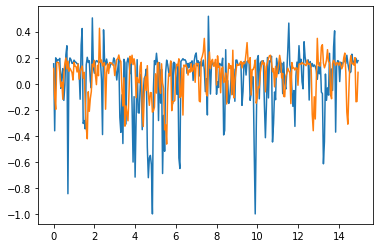

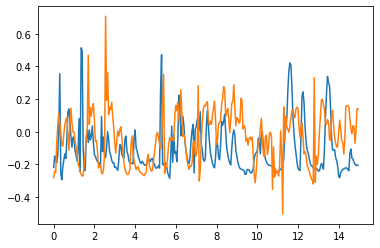

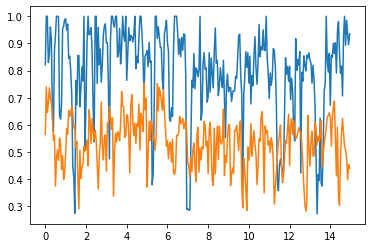

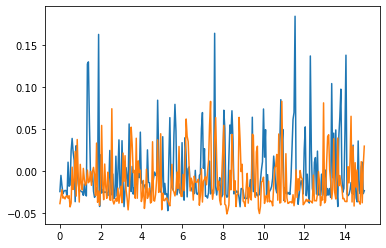

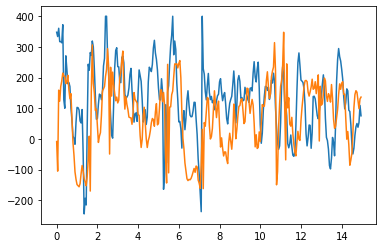

In [48]:
for i in range(5):
    plt.figure()
    #plt.plot([j*0.05 for j in range(features_ori.shape[0])],features_ori[:,i])
    #plt.plot([j*0.05 for j in range(features_pred.shape[0])],features_pred[:,i])
    plt.plot([j*0.05 for j in range(300)],features_ori[:300,i])
    plt.plot([j*0.05 for j in range(300)],features_pred[:300,i])

In [72]:
#bugs here
tfeatures=features_pred
wave_timeindexs_ori_arr=np.array(wave_timeindexs_ori);
for i in range(len(wave_timeindexs)):
    t=np.abs(wave_timeindexs_ori_arr-wave_timeindexs[i]);
    t=np.where(t==np.min(t))[0][0];
    for j in range(5):
        tfeatures[i,j]=min(max(features_ori[t,j]-(features_ori[t,j]-features_pred[i,j])*0.5,range_param[j][0]),range_param[j][1])

f=open("D:\\autocover_test\\param.txt","w")
i=0
while i<len(wave_timeindexs):
    f.write(str.format('%.3f '%(tfeatures[i,0]*1.1))) #tension
    f.write(str.format('%.3f '%tfeatures[i,1])) #breathiness
    f.write(str.format('%.3f '%(tfeatures[i,2]))) #voicing
    f.write(str.format('%.3f '%tfeatures[i,3])) #gender
    f.write(str.format('%.3f '%(tfeatures[i,4]*1.1))) #toneshift
    f.write(str.format('%.3f\n'%(wave_timeindexs[i]*0.05)))
    i=i+1
f.close()

In [55]:
print(wave_timeindexs_ori[-10:])

[2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104]


In [54]:
print(len(e))

2128


In [56]:
print(wave_timeindexs[-10:])

[2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111]


1568
1575


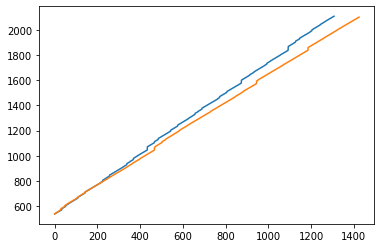

In [69]:
print(wave_timeindexs_ori[-1]-wave_timeindexs_ori[0])
print(wave_timeindexs[-1]-wave_timeindexs[0])
plt.plot([i for i in range(len(wave_timeindexs))],wave_timeindexs)
plt.plot([i for i in range(len(wave_timeindexs_ori))],wave_timeindexs_ori)
